In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np
import requests
from io import BytesIO

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from IPython.display import Image as image
from IPython.core.display import HTML 

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

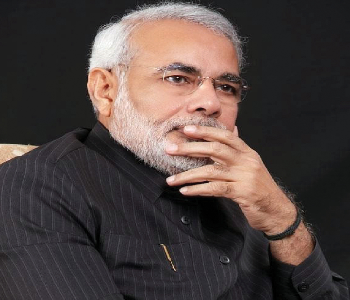

In [2]:
response=requests.get('http://web.unep.org/sites/unep.org.championsofearth/files/COE2018-Modi.jpg')
content_image = Image.open(BytesIO(response.content))
content_image = content_image.resize((350, 300))
content_image

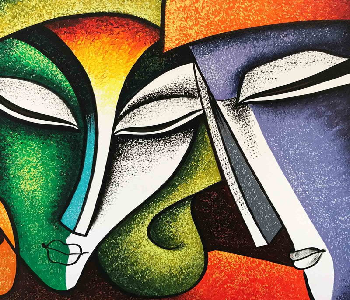

In [3]:
style_image_path = '/kaggle/input/mod1.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((350,300))
style_image

In [4]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 300, 350, 3)
(1, 300, 350, 3)


In [5]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [6]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1,300, 350, 3))

In [7]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [8]:
input_tensor

<tf.Tensor 'concat:0' shape=(3, 300, 350, 3) dtype=float32>

In [9]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [10]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 300, 350, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 300, 350, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 300, 350, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 150, 175, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 150, 175, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 150, 175, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 75, 87, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 75, 87, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 75, 87, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 75, 87, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 37, 43, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor

In [11]:
loss = backend.variable(0.)
content_weight = 0.1
style_weight = 5.0
total_variation_weight = 5.0

In [12]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [13]:
layer_features

<tf.Tensor 'block2_conv2/Relu:0' shape=(3, 150, 175, 128) dtype=float32>

In [14]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [15]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = 350*300
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [16]:
height=300
width=350

In [17]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [18]:
grads = backend.gradients(loss, combination_image)

In [19]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [20]:
def save_img(y,i):
    y = y.reshape((height, width, 3))
    y = y[:, :, ::-1]
    y[:, :, 0] += 103.939
    y[:, :, 1] += 116.779
    y[:, :, 2] += 123.68
    y = np.clip(y, 0, 255).astype('uint8')
    y=Image.fromarray(y)
    y.save("result"+str(i)+'.jpeg')

In [21]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 15
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    #save_img(x,i)
    
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 286466600000.0
Iteration 0 completed in 4s
Start of iteration 1
Current loss value: 188602060000.0
Iteration 1 completed in 1s
Start of iteration 2
Current loss value: 150439360000.0
Iteration 2 completed in 1s
Start of iteration 3
Current loss value: 134791570000.0
Iteration 3 completed in 1s
Start of iteration 4
Current loss value: 126421360000.0
Iteration 4 completed in 1s
Start of iteration 5
Current loss value: 121973860000.0
Iteration 5 completed in 1s
Start of iteration 6
Current loss value: 119348740000.0
Iteration 6 completed in 1s
Start of iteration 7
Current loss value: 117528030000.0
Iteration 7 completed in 1s
Start of iteration 8
Current loss value: 116161350000.0
Iteration 8 completed in 1s
Start of iteration 9
Current loss value: 115155870000.0
Iteration 9 completed in 1s
Start of iteration 10
Current loss value: 114411635000.0
Iteration 10 completed in 1s
Start of iteration 11
Current loss value: 113794925000.0
Iteration 11 comp

In [22]:
#Image.open("result0.jpeg")

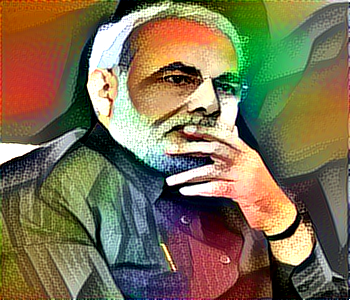

In [23]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

In [24]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

In [25]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

In [26]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

In [27]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

In [28]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

In [29]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

In [30]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'